# AI 모델 구현: 온도 및 전령량 예측

온도 및 사용된 전령량을 예측하고 각 센서의 예측값을 REST API로 통해 반환할 수 있도록 구현하였습니다.

---

## 1. Import

In [153]:
from influxdb_client import InfluxDBClient # type: ignore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from dotenv import load_dotenv
import os
from datetime import datetime

## 2. 데이터 준비

- ### 환경 변수 적용

In [154]:
# InfluxDB 접속 정보 불러오기
load_dotenv('parameters.env')

DB_URL = os.getenv('DB_URL')
DB_TOKEN = os.getenv('DB_TOKEN')
DB_ORG = os.getenv('DB_ORG')
DB_BUCKET = os.getenv('DB_BUCKET')

print('DB_URL',DB_URL)
print('DB_TOKEN',DB_TOKEN)
print('DB_ORG',DB_ORG)
print('DB_BUCKET',DB_BUCKET)

DB_URL http://180.210.83.241:8086/
DB_TOKEN pu3lGvm4S1TqTq0WBv2mRFDGqOvfhMxH4-hz33TSw8dh9xBZcRUnmTKfeH2Za2Oil6oMVyfYzI2A9zQvKoSfpQ==
DB_ORG databo3
DB_BUCKET raw_data


- ### InfluxDB에 접속하여 필요한 센서 데이터 가져오기

In [155]:
# dataset의 정보 출력
def print_df_info(dataset, sensor_type):
    pd.set_option('display.max_columns', None)  # Display all columns
    pd.set_option('display.max_rows', None)     # Display all rows
    pd.set_option('display.width', None)        # Set the display width to None

    print('='*30)
    print(dataset.info())
    print('='*30)
    print("Column Names: ",dataset.columns)
    print('='*30)
    print("Data types:\n",dataset.dtypes)
    print('='*30)
    print("Summary statistics:\n",dataset.describe())
    print('='*30)
    print(dataset.isnull().sum())
    print('='*30)
    print(dataset.head(30))
    print('='*30)
    print('Index of Dataframe: ',dataset.index.name)
    print('='*30)
    print(dataset.corr()[sensor_type].sort_values(ascending=False))

In [156]:
# dataset을 그래프로 표현
def draw_table(sensor_type, dataset):
    """
    데이터 프레임을 그래프로 표현합니다.
    
    Args:
        dataset (DataFrame): 그래프로 표현할 데이터 프레임.
    """

    plt.figure(figsize=(16,8))
    sns.lineplot(data=dataset, palette='Set1')
    plt.xlabel('Time')
    plt.ylabel(sensor_type)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [157]:
# 데이터 쿼리를 위한 시작 및 종료 시간을 반환
def start_end_time():
    now = datetime.now()
    start_time = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    start_iso = start_time.isoformat() + 'Z'
    end_iso = now.isoformat() + 'Z'

    return [start_iso, end_iso]

In [158]:
# 온도 데이터 가져오기
def query_sensor_data(client, bucket, branch, sensor_type):
    query_api = client.query_api()
    
    query = f'from(bucket: "{bucket}")\
        |> range(start: -7d)\
        |> filter(fn: (r) => r["_measurement"] == "databo3")\
        |> filter(fn: (r) => r["endpoint"] == "{sensor_type}")\
        |> filter(fn: (r) => r.branch == "{branch}")\
        |> group(columns: ["branch"])\
        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)\
        |> yield(name: "sensor_value")'
    
    print("Query: ",query)
    result_df = query_api.query_data_frame(query=query)
    return result_df

In [159]:
# 전력량 데이터 가져오기
def query_energy(client, bucket, branch, sensor_type):
    query_api = client.query_api()
    datetimes = start_end_time()
    
    query = f'from(bucket: "{bucket}")\
        |> range(start: {datetimes[0]}, stop: {datetimes[1]})\
        |> filter(fn: (r) => r["_measurement"] == "databo3")\
        |> filter(fn: (r) => r["endpoint"] == "{sensor_type}")\
        |> filter(fn: (r) => r["phase"] == "total")\
        |> filter(fn: (r) => r["description"] == "w")\
        |> group(columns: ["branch"])\
        |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)\
        |> yield(name: "sensor_value")'
    
    print("Query: ",query)
    result_df = query_api.query_data_frame(query=query)
    return result_df

In [160]:
# 환경 변수 선언
client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
bucket = DB_BUCKET
branch = 'nhnacademy'

In [161]:
# 온도 데이터셋 준비
raw_df_temp = query_sensor_data(client, bucket, branch, 'temperature')

# 에너지 데이터셋 준비
raw_df_energy = query_energy(client, bucket, branch, 'electrical_energy')

client.close()

Query:  from(bucket: "raw_data")        |> range(start: -7d)        |> filter(fn: (r) => r["_measurement"] == "databo3")        |> filter(fn: (r) => r["endpoint"] == "temperature")        |> filter(fn: (r) => r.branch == "nhnacademy")        |> group(columns: ["branch"])        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)        |> yield(name: "sensor_value")
Query:  from(bucket: "raw_data")        |> range(start: 2024-05-01T00:00:00Z, stop: 2024-05-22T10:24:01.532516Z)        |> filter(fn: (r) => r["_measurement"] == "databo3")        |> filter(fn: (r) => r["endpoint"] == "electrical_energy")        |> filter(fn: (r) => r["phase"] == "total")        |> filter(fn: (r) => r["description"] == "w")        |> group(columns: ["branch"])        |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)        |> yield(name: "sensor_value")


/home/sein/anaconda3/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "raw_data")        |> range(start: -7d)        |> filter(fn: (r) => r["_measurement"] == "databo3")        |> filter(fn: (r) => r["endpoint"] == "temperature")        |> filter(fn: (r) => r.branch == "nhnacademy")        |> group(columns: ["branch"])        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)        |> yield(name: "sensor_value") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.inf

In [162]:
print('='*30)
print(raw_df_temp.info())
print('='*30)
print("Column Names: ",raw_df_temp.columns)
print('='*30)
print("Data types:\n",raw_df_temp.dtypes)
print('='*30)
print("Summary statistics:\n",raw_df_temp.describe())
print('='*30)
print(raw_df_temp.isnull().sum())
print('='*30)
print(raw_df_temp.head(30))
print('='*30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   result  141 non-null    object                 
 1   table   141 non-null    int64                  
 2   _time   141 non-null    datetime64[ns, tzutc()]
 3   _start  141 non-null    datetime64[ns, tzutc()]
 4   _stop   141 non-null    datetime64[ns, tzutc()]
 5   branch  141 non-null    object                 
 6   _value  141 non-null    float64                
dtypes: datetime64[ns, tzutc()](3), float64(1), int64(1), object(2)
memory usage: 8.8+ KB
None
Column Names:  Index(['result', 'table', '_time', '_start', '_stop', 'branch', '_value'], dtype='object')
Data types:
 result                     object
table                       int64
_time     datetime64[ns, tzutc()]
_start    datetime64[ns, tzutc()]
_stop     datetime64[ns, tzutc()]
branch                     object
_

In [163]:
print('='*30)
print(raw_df_energy.info())
print('='*30)
print("Column Names: ",raw_df_energy.columns)
print('='*30)
print("Data types:\n",raw_df_energy.dtypes)
print('='*30)
print("Summary statistics:\n",raw_df_energy.describe())
print('='*30)
print(raw_df_energy.isnull().sum())
print('='*30)
print(raw_df_energy.head(30))
print('='*30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1665
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   result  1666 non-null   object                 
 1   table   1666 non-null   int64                  
 2   _time   1666 non-null   datetime64[ns, tzutc()]
 3   _start  1666 non-null   datetime64[ns, tzutc()]
 4   _stop   1666 non-null   datetime64[ns, tzutc()]
 5   branch  1666 non-null   object                 
 6   _value  1666 non-null   float64                
dtypes: datetime64[ns, tzutc()](3), float64(1), int64(1), object(2)
memory usage: 104.1+ KB
None
Column Names:  Index(['result', 'table', '_time', '_start', '_stop', 'branch', '_value'], dtype='object')
Data types:
 result                     object
table                       int64
_time     datetime64[ns, tzutc()]
_start    datetime64[ns, tzutc()]
_stop     datetime64[ns, tzutc()]
branch                     obje

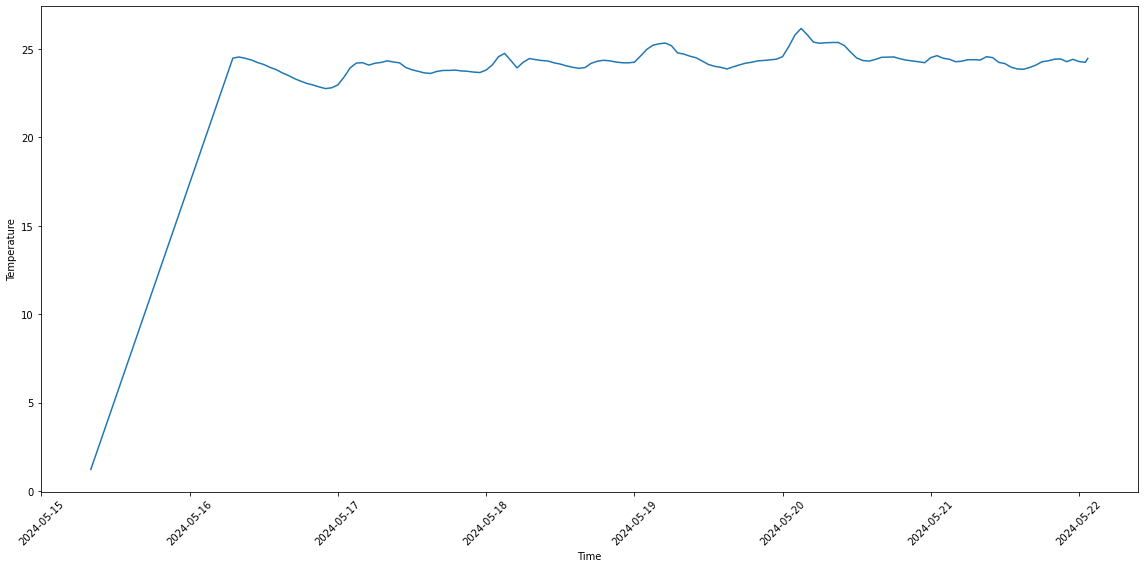

In [164]:
plt.figure(figsize=(16,8))
sns.lineplot(x='_time',y='_value',data=raw_df_temp, palette='Set1')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

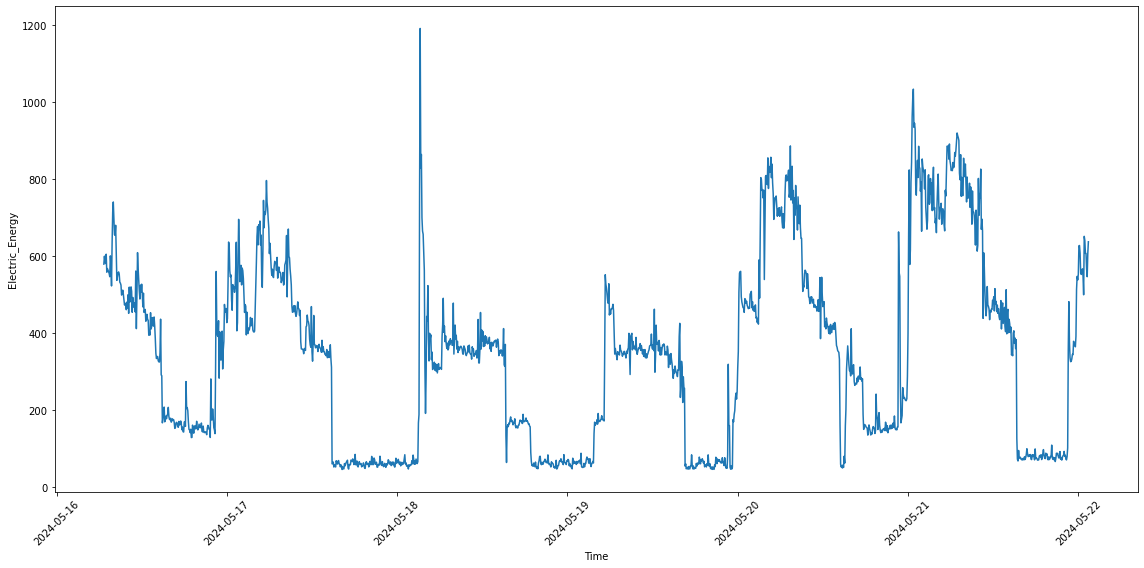

In [165]:
plt.figure(figsize=(16,8))
sns.lineplot(x='_time',y='_value',data=raw_df_energy, palette='Set1')
plt.xlabel('Time')
plt.ylabel('Electric_Energy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- ### 데이터 전처리

In [166]:
# 이상치 제거
def outlier_processing(raw_dataset, sensor_type):
    # 중복값 제거
    raw_dataset = raw_dataset[~raw_dataset.index.duplicated(keep='first')]

    # 누락된 시간대 생성
    if sensor_type=='electrical_energy':
        full_index = pd.date_range(start=raw_dataset.index.min(), end=raw_dataset.index.max(), freq='5min')
    else:
        full_index = pd.date_range(start=raw_dataset.index.min(), end=raw_dataset.index.max(), freq='H')

    # reindexing
    raw_dataset = raw_dataset.reindex(full_index)

    # 누락된 row에 branch 값을 채우기
    # raw_dataset['branch'].fillna(raw_dataset['branch'].mode()[0], inplace=True)

    # nan 값에 평균값으로 채우기
    mean_value = raw_dataset[sensor_type].mean(skipna=True)
    raw_dataset[sensor_type].fillna(mean_value, inplace=True)
        
    raw_dataset[sensor_type] = raw_dataset[sensor_type].interpolate(method='linear')

    fig = plt.figure()

    fig_1 = fig.add_subplot(1,2,1)
    fig_2 = fig.add_subplot(1,2,2)

    fig_1.set_title('Original Data Boxplot')
    fig_1.boxplot(raw_dataset)
    
    print('-'*30)
    print(np.percentile(raw_dataset,25))
    print(np.percentile(raw_dataset,50))
    print(np.median(raw_dataset))
    print(np.percentile(raw_dataset,75))

    iqr_value = np.percentile(raw_dataset[sensor_type].dropna(), 75) - np.percentile(raw_dataset[sensor_type].dropna(), 25)
    print('IQR_value : {}'.format(iqr_value))

    upper_bound = iqr_value * 1.5 + np.percentile(raw_dataset[sensor_type].dropna(), 75)
    print('upper_bound : {}'.format(upper_bound)) # 보다 큰 값은 이상치

    lower_bound = np.percentile(raw_dataset[sensor_type].dropna(), 25) - iqr_value * 1.5
    print('lower_bound : {}'.format(lower_bound)) # 보다 작은 값은 이상치

    # 데이터에서 이상치를 출력
    print(raw_dataset[(raw_dataset > upper_bound) | (raw_dataset < lower_bound)])

    result_data = raw_dataset[(raw_dataset[sensor_type]<=upper_bound) & (raw_dataset[sensor_type] >= lower_bound)]
    result_data[sensor_type].fillna(method='bfill', inplace=True)
    result_data[sensor_type] = result_data[sensor_type].interpolate(method='linear')
    print('이상치 제거 후 데이터 : {}'.format(result_data))
    print('-'*30)

    fig_2.set_title('Remove Outlier Data Boxplot')
    fig_2.boxplot(result_data)

    fig.tight_layout()
    plt.show()

    return result_data

In [167]:
# 데이터 전처리
def data_preprocessing(sensor_type, raw_dataset):
    # dataframe 중요한 column 가져오기
    if 'place' in raw_dataset.columns:
        df = raw_dataset[['_time', 'place', '_value']].copy()
        
        # 냉장고 지우기
        if '냉장고' in df['place'].values:
            df = df[df['place'] != '냉장고']
            df = df.drop(columns=['place'])
    else:
        df = raw_dataset[['_time', '_value']].copy()
    
    # 기존 column 이름 변경하기
    df.rename(columns={'_time':'date'}, inplace=True)
    df.rename(columns={'_value': sensor_type}, inplace=True)

    # date asia 시간대로 바꾸기
    df['date'] = pd.to_datetime(df['date']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)

    # date를 index로 set하기
    df = df.set_index('date')

    # branch 컬럼을 integer 값으로 매핑하기
    # branch_mapping = {label: idx for idx, label in enumerate(df['branch'].unique())}
    # df['branch'] = df['branch'].map(branch_mapping)

    # 결측지를 전체의 평균값으로 채우기
    df = outlier_processing(df, sensor_type)        

    # 가공된 dataframe의 정보 출력
    print_df_info(df, sensor_type)
    
    return df

------------------------------
24.019112672391365
24.21719576719576
24.21719576719576
24.41371365196112
IQR_value : 0.3946009795697556
upper_bound : 25.005615121315756
lower_bound : 23.427211203036734
                     temperature
2024-05-15 17:00:00     1.223000
2024-05-15 18:00:00          NaN
2024-05-15 19:00:00          NaN
2024-05-15 20:00:00          NaN
2024-05-15 21:00:00          NaN
2024-05-15 22:00:00          NaN
2024-05-15 23:00:00          NaN
2024-05-16 00:00:00          NaN
2024-05-16 01:00:00          NaN
2024-05-16 02:00:00          NaN
2024-05-16 03:00:00          NaN
2024-05-16 04:00:00          NaN
2024-05-16 05:00:00          NaN
2024-05-16 06:00:00          NaN
2024-05-16 07:00:00          NaN
2024-05-16 08:00:00          NaN
2024-05-16 09:00:00          NaN
2024-05-16 10:00:00          NaN
2024-05-16 11:00:00          NaN
2024-05-16 12:00:00          NaN
2024-05-16 13:00:00          NaN
2024-05-16 14:00:00          NaN
2024-05-16 15:00:00          NaN
2024-05

/tmp/ipykernel_53058/978187529.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_data[sensor_type].fillna(method='bfill', inplace=True)
/tmp/ipykernel_53058/978187529.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_data[sensor_type] = result_data[sensor_type].interpolate(method='linear')


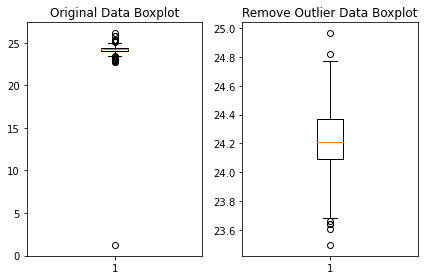

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2024-05-15 18:00:00 to 2024-05-22 10:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  138 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB
None
Column Names:  Index(['temperature'], dtype='object')
Data types:
 temperature    float64
dtype: object
Summary statistics:
        temperature
count   138.000000
mean     24.194731
std       0.269028
min      23.495337
25%      24.090290
50%      24.211558
75%      24.369221
max      24.965414
temperature    0
dtype: int64
                     temperature
2024-05-15 18:00:00    24.093502
2024-05-15 19:00:00    24.093502
2024-05-15 20:00:00    24.093502
2024-05-15 21:00:00    24.093502
2024-05-15 22:00:00    24.093502
2024-05-15 23:00:00    24.093502
2024-05-16 00:00:00    24.093502
2024-05-16 01:00:00    24.093502
2024-05-16 02:00:00    24.093502
2024-05-16 03:00:00    24.093502

/tmp/ipykernel_53058/978187529.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_data[sensor_type].fillna(method='bfill', inplace=True)
/tmp/ipykernel_53058/978187529.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_data[sensor_type] = result_data[sensor_type].interpolate(method='linear')


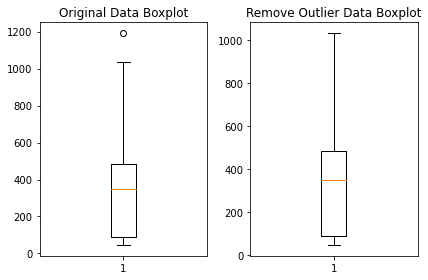

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1665 entries, 2024-05-16 15:40:00 to 2024-05-22 10:25:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   electrical_energy  1665 non-null   float64
dtypes: float64(1)
memory usage: 26.0 KB
None
Column Names:  Index(['electrical_energy'], dtype='object')
Data types:
 electrical_energy    float64
dtype: object
Summary statistics:
        electrical_energy
count        1665.000000
mean          341.099607
std           236.564681
min            44.868966
25%            87.593103
50%           349.062069
75%           485.037931
max          1034.175862
electrical_energy    0
dtype: int64
                     electrical_energy
2024-05-16 15:40:00         579.006897
2024-05-16 15:45:00         599.600000
2024-05-16 15:50:00         584.993103
2024-05-16 15:55:00         580.579310
2024-05-16 16:00:00         604.827586
2024-05-16 16:05:00         558.0344

In [168]:
# 온도 데이터 전처리
pre_df_temp = data_preprocessing('temperature', raw_df_temp)

# 에너지 데이터 전처리
pre_df_energy = data_preprocessing('electrical_energy', raw_df_energy)

## 3. 모델 학습 (Linear Regression)

- ### 데이터셋 분할 및 모델 학습

In [169]:
models = {}
X_tests = {}
y_tests = {}
predictions = {}
accuracies = {}

In [170]:
# 선형 회귀 모델 학습
def train_lr_model(sensor_type, df):
    # linear regression model용 dataset 만들기
    split_ratio = int(len(df) * 0.9)
    lr_df = df.copy()

    # lagged feature 생성 및 값 shifting
    lr_df[sensor_type+'.L1'] = lr_df[sensor_type].shift(1)
    lr_df.dropna(inplace=True)

    # target & feature 정의
    lr_y = lr_df[sensor_type]
    lr_X = lr_df.drop(columns=sensor_type)

    # train & test 데이터 분리
    X_train, y_train = lr_X.iloc[:split_ratio], lr_y.iloc[:split_ratio]
    X_test, y_test = lr_X.iloc[split_ratio:], lr_y.iloc[split_ratio:]

    # Baseline model
    y_pred_baseline = [y_train.mean()] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print("Mean Close Prices:", round(y_train.mean(), 2))
    print("Baseline MAE:", round(mae_baseline, 2))
    print('-'*30)
    print('LR X_test : ', X_test[:10])
    print('LR X_test type :', type(X_test))

    # 모델 생성 및 학습
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    models[sensor_type] = lr_model
    predictions[sensor_type] = pd.Series(lr_model.predict(X_test), index=y_test.index)
    X_tests[sensor_type] = X_test
    y_tests[sensor_type] = y_test

In [171]:
train_lr_model('temperature', pre_df_temp)
train_lr_model('electrical_energy', pre_df_energy)

Mean Close Prices: 24.2
Baseline MAE: 0.22
------------------------------
LR X_test :                       temperature.L1
2024-05-21 22:00:00       24.166216
2024-05-21 23:00:00       23.961316
2024-05-22 00:00:00       23.864230
2024-05-22 01:00:00       23.845932
2024-05-22 02:00:00       23.947287
2024-05-22 03:00:00       24.080577
2024-05-22 04:00:00       24.271429
2024-05-22 05:00:00       24.321875
2024-05-22 06:00:00       24.414767
2024-05-22 07:00:00       24.428646
LR X_test type : <class 'pandas.core.frame.DataFrame'>
Mean Close Prices: 349.85
Baseline MAE: 195.73
------------------------------
LR X_test :                       electrical_energy.L1
2024-05-21 20:40:00            458.341379
2024-05-21 20:45:00            453.682759
2024-05-21 20:50:00            462.020690
2024-05-21 20:55:00            460.955172
2024-05-21 21:00:00            485.037931
2024-05-21 21:05:00            480.210345
2024-05-21 21:10:00            494.079310
2024-05-21 21:15:00            457.

- ### 모델 평가

In [172]:
# 모델 평가
def evaluate_models():
    for name, prediction in predictions.items():
        evs = explained_variance_score(y_tests[name], prediction)
        mae = mean_absolute_error(y_tests[name], prediction)
        mse = mean_squared_error(y_tests[name], prediction)
        rmse = mean_squared_error(y_tests[name], prediction, squared=False)
        r2 = r2_score(y_tests[name], prediction)

        accuracies[name] = {'Explained Variance': evs,
                            'Mean Absolute Error': mae,
                            'Mean Squared Error': mse,
                            'Root Mean Squared Error': rmse,
                            'R² Score': r2}

In [173]:
# 예측 그래프으로 그리기
def draw_prediction(sensor_type, model_name, X_test, y_test, y_pred):
    X_test_sorted = y_test.index
    y_test_sorted = y_test
    y_pred_sorted = y_pred

    if model_name=='RandomForest':
        sorted_indices = np.argsort(X_test[:, 0])
        X_test_sorted = X_test[sorted_indices]
        y_test_sorted = y_test.iloc[sorted_indices]
        y_pred_sorted = y_pred[sorted_indices]

    plt.figure()
    plt.plot(X_test_sorted, y_test_sorted, label='Actual Values')
    plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel(sensor_type)
    plt.legend()
    plt.grid()
    plt.show()

In [174]:
evaluate_models()

In [175]:
# 점수 출력
print('EVALUATION SCORES: ')
for sensor, models in accuracies.items():
    print(f"Sensor: {sensor}")
    for model, scores in models.items():
        print(f"{model}: {scores}")
    print('-'*30)

EVALUATION SCORES: 
Sensor: temperature
Explained Variance: 0.6864394501706073
Mean Absolute Error: 0.10281020244836014
Mean Squared Error: 0.013124718877723254
Root Mean Squared Error: 0.11456316544912354
R² Score: 0.6863699063292596
------------------------------
Sensor: electrical_energy
Explained Variance: 0.9544874623157151
Mean Absolute Error: 22.920682549828626
Mean Squared Error: 1823.0993941155605
Root Mean Squared Error: 42.69776802264447
R² Score: 0.9544694850862097
------------------------------


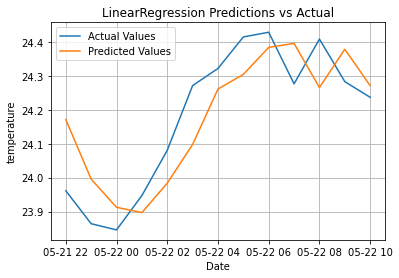

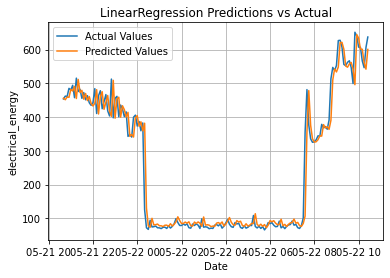

In [176]:
for sensor, models in accuracies.items():
    draw_prediction(sensor, 'LinearRegression', X_tests[sensor], y_tests[sensor], predictions[sensor])